In [1]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt

In [2]:
with tifffile.TiffFile('AKAR3EV_Donor.tif') as tif:
    donor = tif.asarray()
    
with tifffile.TiffFile('AKAR3EV_Acceptor.tif') as tif:
    acceptor = tif.asarray()
    
acceptor.shape

(10, 256, 256)

max: 2555
min: 0
mean: 820.8073547363281
std: 742.6906519140636


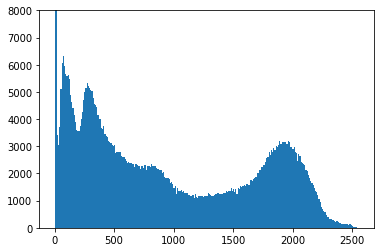

In [3]:
print('max:',np.max(donor))
print('min:',np.min(donor))
print('mean:',np.mean(donor))
print('std:',np.std(donor))
plt.hist(donor.ravel(), 256,[np.min(donor),np.max(donor)])
plt.ylim(0,8000)
plt.show()

max: 3593
min: 0
mean: 1593.0726745605468
std: 1179.7164175009248


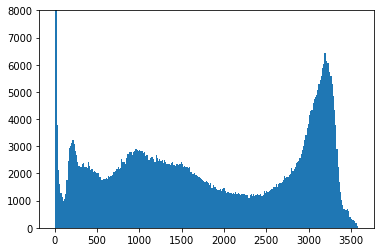

In [4]:
print('max:',np.max(acceptor))
print('min:',np.min(acceptor))
print('mean:',np.mean(acceptor))
print('std:',np.std(acceptor))
plt.hist(acceptor.ravel(), 256,[np.min(acceptor),np.max(acceptor)])
plt.ylim(0,8000)
plt.show()

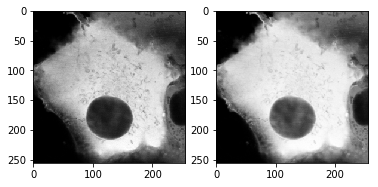

In [5]:
plt.subplot(121)
plt.imshow(donor[0],'gray')
plt.subplot(122)
plt.imshow(acceptor[0],'gray')
plt.show()

In [6]:
D_frame = donor[0]
A_frame = acceptor[0]

A_frame[D_frame == 0]=0
D_frame[D_frame == 0]=999999

ratio = A_frame/D_frame
ratio.dtype

dtype('float64')

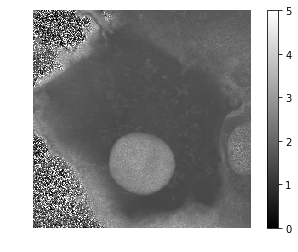

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(ratio,'gray')
im.set_clim(0,5)
fig.colorbar(im, ax=ax)
plt.axis('off')
plt.show()

In [8]:
import math

def hsv2rgb(h, s, v):
    h = float(h)
    s = float(s)
    v = float(v)
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return r, g, b

In [9]:
def RGBForRatioIntensity(ratio, minRatio, maxRatio, intensity, minIntensity, maxIntensity):
    hue = (ratio - minRatio) / (maxRatio-minRatio) * 300
    hue = np.clip(hue, 0, 300)
    value = (intensity - minIntensity) / (maxIntensity - minIntensity)
    value = np.clip(value, 0, 1)
    saturation = 1
    
    return hsv2rgb(hue, saturation, value)

In [10]:
def IMDImage(RatioImage, IntensityImage, minRatio, maxRatio, minIntensity, maxIntensity):
    M_IMD = np.empty((RatioImage.shape[0],RatioImage.shape[1],3), dtype=float)
    for row in range(RatioImage.shape[0]):
        for col in range(RatioImage.shape[1]):
            (red, green, blue) = RGBForRatioIntensity(RatioImage[row, col], minRatio, maxRatio, IntensityImage[row, col], minIntensity, maxIntensity)
            M_IMD[row,col,0] = red*65535
            M_IMD[row,col,1] = green*65535
            M_IMD[row,col,2] = blue*65535
    return M_IMD

In [11]:
from matplotlib import colors
def array2cmpa(X):
    # Assuming array is Nx3, where x3 gives RGB values
    # Append 1's for the alpha channel, to make X Nx4
    X = np.c_[X,np.ones(len(X))]

    return colors.LinearSegmentedColormap.from_list('my_colormap', X)

In [12]:
FakeRatio = np.linspace(0,1, num=256)
FakeIntensity = np.ones((1,256), dtype=float)
FakeRatio = np.reshape(FakeRatio, (256,1))
FakeIntensity = np.reshape(FakeIntensity, (256,1))
ColorBar = np.empty((256,3))
ColorBar[:,0] = (IMDImage(FakeRatio, FakeIntensity, 0,1,0,1)/255)[:,0,0]/65535
ColorBar[:,1] = (IMDImage(FakeRatio, FakeIntensity, 0,1,0,1)/255)[:,0,1]/65535
ColorBar[:,2] = (IMDImage(FakeRatio, FakeIntensity, 0,1,0,1)/255)[:,0,2]/65535
cmap = array2cmpa(ColorBar)

In [13]:
minInt = 0
maxInt = 5000
minRatio = 0
maxRatio = 5
IMAGE = IMDImage(ratio, D_frame, minRatio, maxRatio, minInt , maxInt)
IMAGE.shape

(256, 256, 3)

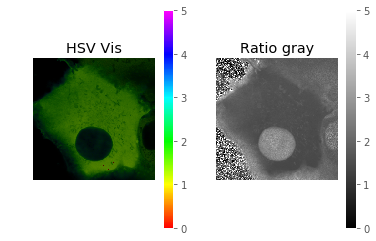

In [14]:
plt.style.use("ggplot")
fig, (ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(IMAGE, cmap=cmap)
im1.set_clim(minRatio,maxRatio)
fig.colorbar(im1, ax=ax1)
ax1.axis('off')
ax1.set(title="HSV Vis")
im2 = ax2.imshow(ratio, 'gray')
im2.set_clim(minRatio,maxRatio)
fig.colorbar(im2, ax=ax2)
ax2.axis('off')
ax2.set(title="Ratio gray")
plt.show()

In [15]:
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib widget
fig, ax1 = plt.subplots()
im1 = ax1.imshow(IMAGE, cmap=cmap)
im1.set_clim(minRatio,maxRatio)
fig.colorbar(im1, ax=ax1)
ax1.axis('off')
ax1.set(title="HSV Vis")
axcolor = 'lightgoldenrodyellow'
axMinRatio = plt.axes([0.99, 0.8, 5, 0.05], facecolor=axcolor, label='minratio')
sMinRatio = Slider(axMinRatio, 'Min Ratio', 0, 10, valinit=5)

axMaxRatio = plt.axes([0.2, 0.02, 0.65, 0.05], facecolor=axcolor, label='maxratio')
sMaxRatio = Slider(axMaxRatio, 'Max Ratio', 0, 10, valinit=5)

axMinInt = plt.axes([0.2, 0.05, 0.65, 0.05], facecolor=axcolor, label='minint')
sMinInt = Slider(axMinInt, 'Min Intensity', 0, 10, valinit=5)

axMaxInt = plt.axes([0.2, 0.05, 0.65, 0.05], facecolor=axcolor, label='maxint')
sMaxInt = Slider(axMaxInt, 'Max Intensity', 0, 10, valinit=5)
plt.show()

def update(val):
    maxRatio = sRatio.val
    IMAGE = IMDImage(ratio, D_frame, minRatio, maxRatio, minInt , maxInt)
    ax1.imshow(IMAGE, cmap=cmap)
    im1.set_clim(vmin=minRatio,vmax=maxRatio)
    fig.canvas.draw_idle()
    
sRatio.on_changed(update)

FigureCanvasNbAgg()

NameError: name 'sRatio' is not defined